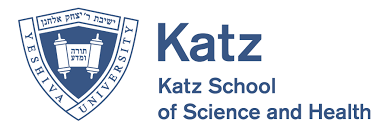

# Jesus Olivera
## Yeshiva University, DAV
## Independent Study: Data Labeling Tool 

Consider these tips for working with this notebook:
- Notebook code serves as a logical foundation for the development of this project.
- This pipeline is optimized for the original framework and it will have to be updated to reflect the actual enviroment in which it will be deployed.
- Before modifying the pipeline or trying to re-fit the pipeline, consider evaluating system integration and tools setup.
- A twitter developer account needs to be provisioned prior to seting up the pipelines.

## Notebook Content

This notebook contains a logical framework for text Twitter data mining following an API extraction logic based on the inputs from a glossary. A pre-evaluation/pre-processing mechanism that leverages NLP Python libraries to score sentiment handles the flows of data into an Object Storage (S3) which syncs outputs into a labeling project with the purpose of having users annotate data using pre-defined labels.  

Familiarity with data engineering (DE) and data science (DS) is required.

## Notebook Goals 

- Pipeline Definition
- Pipeline Integration
- Pipeline Evaluation

## Step 1: Importing Libraries

In [2]:
# Importing libraries
import sys
#!{sys.executable} -m pip install <library>
import pandas as pd
import datetime as dt
import os
import tweepy
import random
from urllib.request import urlopen, Request
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
%matplotlib inline
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import numpy as np
from timeit import timeit
import boto3
import s3fs
import datetime as dt

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\PC\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


## Twitter Setup

In [3]:
# SECURITY: Save keys in a separate file and run it in this file using the code below:

# %run ./<filename>.ipynb


# Authentication Credentials **Remove for security**
consumer_key = "<CONSUMER KEY>"
consumer_secret = "<CONSUMER SECRET>"
access_token = "<ACCESS TOKEN>"
access_token_secret = "<ACCESS TOKEN SECRET>"

In [4]:
# Authenticating Access

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth)

## Glossary Setup

In [5]:
# Automating the query word selection for API calls 

my_glossary = ["jews","khazars","holocaust denial","Jews","Khazars","Holocaust Denial", "JEWS","KHAZARS"]

# Randomizing query word selection
query = random.choice(my_glossary)

## Twitter API Calls

In [6]:
# Enabling Twitter navigation: Searching by Key Words "test"

cursor = tweepy.Cursor(api.search_tweets, q= query , tweet_mode="extended").items(1)

In [7]:
# Printing "Test" Results

for i in cursor:
    print(i.full_text)

RT @ADavidGordon: Archeologists: There's no evidence to prove the Khazar myth.

Historians: The timeline doesn't make any sense. 

Genetic…


In [8]:
# Setting up Extraction method for pipeline data feeding

number_of_tweets = 2000
tweets = []
likes = []
time = []

for i in tweepy.Cursor(api.search_tweets, q=query, tweet_mode="extended").items(number_of_tweets):
    tweets.append(i.full_text)
    likes.append(i.favorite_count)
    time.append(i.created_at)
    

In [9]:
# Array to Dataframe

df = pd.DataFrame({'tweets':tweets, 'likes':likes, 'time':time})

df

,tweets,likes,time
0,RT @ADavidGordon: Archeologists: There's no ev...,0,2022-04-23 15:44:11+00:00
1,RT @ADavidGordon: Archeologists: There's no ev...,0,2022-04-23 14:56:19+00:00
2,People have no friggin idea how far back the e...,0,2022-04-23 14:56:15+00:00
3,RT @Anna_C_moi: @MitchRagnarson Je reposte cet...,0,2022-04-23 14:55:30+00:00
4,@classiCowboy13 @SSaint1611 The one who claim ...,0,2022-04-23 14:40:02+00:00
...,...,...,...
797,https://t.co/FqHXunZZiS,0,2022-04-15 11:00:48+00:00
798,https://t.co/UwHXH0SRdk,0,2022-04-15 10:59:37+00:00
799,@JackyPat2 @Sarah_Hassan94 Defenders against o...,0,2022-04-15 10:28:36+00:00
800,@DimMyEyes0_0 The Russians forced the evil Kha...,2,2022-04-15 10:23:06+00:00


## Sample EDA

In [10]:
# Data Pre-Processing -- Refinery Flow: Removing Re-Tweets

df = df[~df.tweets.str.contains("RT")].reset_index(drop=True)

df

,tweets,likes,time
0,People have no friggin idea how far back the e...,0,2022-04-23 14:56:15+00:00
1,@classiCowboy13 @SSaint1611 The one who claim ...,0,2022-04-23 14:40:02+00:00
2,UKRAINE - KHAZARS - RUSSIE https://t.co/IKK3xT...,0,2022-04-23 14:30:48+00:00
3,@CHARPENTIERM44 @Carterj37919661 @ClementLanot...,0,2022-04-23 14:23:15+00:00
4,@MitchRagnarson Je reposte cette vidéo sur l'h...,2,2022-04-23 13:48:58+00:00
...,...,...,...
422,https://t.co/FqHXunZZiS,0,2022-04-15 11:00:48+00:00
423,https://t.co/UwHXH0SRdk,0,2022-04-15 10:59:37+00:00
424,@JackyPat2 @Sarah_Hassan94 Defenders against o...,0,2022-04-15 10:28:36+00:00
425,@DimMyEyes0_0 The Russians forced the evil Kha...,2,2022-04-15 10:23:06+00:00


In [11]:
# Most Liked Tweets
mostliked = df.loc[df.likes.nlargest(5).index]

mostliked

,tweets,likes,time
50,Archeologists: There's no evidence to prove th...,228,2022-04-22 16:50:32+00:00
312,Eski Kermen or Eski-Kermen was a cave town and...,187,2022-04-17 21:40:31+00:00
201,#OnTyrannyUkraineEdition\nhttps://t.co/oSFrU1u...,159,2022-04-19 22:38:04+00:00
63,The Khazars existed. Some of their leaders see...,56,2022-04-22 13:43:58+00:00
223,It's really a shame that the Khazars are the f...,50,2022-04-19 16:30:56+00:00


In [24]:
#Droping "Likes" and "time" columns 

tweets_df = df.drop(['likes', 'time'], axis=1)

tweets_df.head(5)

,tweets
0,People have no friggin idea how far back the e...
1,@classiCowboy13 @SSaint1611 The one who claim ...
2,UKRAINE - KHAZARS - RUSSIE https://t.co/IKK3xT...
3,@CHARPENTIERM44 @Carterj37919661 @ClementLanot...
4,@MitchRagnarson Je reposte cette vidéo sur l'h...


## NLP: Sentiment Analysis

In [26]:
# Instantiate the sentiment intensity analyzer
vader = SentimentIntensityAnalyzer()

# Set column names
columns = ['tweets']

# Convert the parsed_tweets list into a DataFrame called 'parsed_and_scored_tweets'
parsed_and_scored_tweets = pd.DataFrame(tweets_df, columns=columns)

# Iterate through the tweets and get the polarity scores using vader
scores = parsed_and_scored_tweets['tweets'].apply(vader.polarity_scores).tolist()

# Convert the 'scores' list of dicts into a DataFrame
scores_df = pd.DataFrame(scores)

# Join the DataFrames of the tweets and the list of dicts
parsed_and_scored_tweets = parsed_and_scored_tweets.join(scores_df, rsuffix='_right')


parsed_and_scored_tweets.head()

,tweets,neg,neu,pos,compound
0,People have no friggin idea how far back the e...,0.078,0.922,0.0,-0.296
1,@classiCowboy13 @SSaint1611 The one who claim ...,0.000,1.000,0.0,0.000
2,UKRAINE - KHAZARS - RUSSIE https://t.co/IKK3xT...,0.000,1.000,0.0,0.000
3,@CHARPENTIERM44 @Carterj37919661 @ClementLanot...,0.036,0.964,0.0,-0.128
4,@MitchRagnarson Je reposte cette vidéo sur l'h...,0.000,1.000,0.0,0.000


In [27]:
# Creating dataframe with negative tweets
neg_tweets = parsed_and_scored_tweets[(parsed_and_scored_tweets.neg > 0 )].reset_index(drop=True)

neg_tweets.head(5)

,tweets,neg,neu,pos,compound
0,People have no friggin idea how far back the e...,0.078,0.922,0.000,-0.2960
1,@CHARPENTIERM44 @Carterj37919661 @ClementLanot...,0.036,0.964,0.000,-0.1280
2,@Petar216 @zavnos1945 After the funeral of the...,0.204,0.764,0.032,-0.8442
3,Khazars are embarrassing.,0.565,0.435,0.000,-0.3818
4,"@HasanErgent I know that bro 😂😂 \n\nExcept, i ...",0.103,0.897,0.000,-0.5043


## Loading dataframe to S3 Bucket

In [28]:
# creating a variable that stores date to be append on the file to be archive
today = dt.datetime.today()
date = today.strftime("%Y%m%d")

#connect and load the historical data file to s3

s3pathName = 's3://<BUCKET NAME>/'
FileNameFullPath = 'neg_tweets' 
filenames3 = "%s%s%s.csv"%(s3pathName,FileNameFullPath,date) #name of the filepath and csv file

neg_tweets.to_csv(filenames3, header=True, line_terminator='\n') 

#print success message
print("Successfull uploaded file to location:"+str(filenames3))

Successfull uploaded file to location:s3://neg-tweets/neg_tweets20220423.csv
